In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
DATA_PATH = "heart.csv"

In [4]:
if not Path(DATA_PATH).is_file():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Place the CSV in the notebook folder or update DATA_PATH.")


In [5]:
df = pd.read_csv(DATA_PATH)
df['HeartDisease'] = df['HeartDisease'].replace({0: 0, 1: 1})

In [6]:
print("=== Quick preview ===")
display(df.head(8))

=== Quick preview ===


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0


In [7]:
print("\n=== Shape ===")
print(df.shape)


=== Shape ===
(918, 12)


In [8]:
print("\n=== Data types ===")
print(df.dtypes)


=== Data types ===
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


In [9]:
print("\n=== Missing values (per column) ===")
print(df.isnull().sum())


=== Missing values (per column) ===
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [10]:
print("\n=== Duplicate rows ===")
print("duplicates:", df.duplicated().sum())


=== Duplicate rows ===
duplicates: 0


In [11]:
TARGET = "HeartDisease"
if TARGET in df.columns:
    print("\n=== Target distribution ===")
    print(df[TARGET].value_counts(dropna=False))
    print("\nTarget distribution (proportions):")
    print(df[TARGET].value_counts(normalize=True))
else:
    print(f"\nWARNING: Target column '{TARGET}' not found. Please set TARGET variable correctly.")


=== Target distribution ===
HeartDisease
1    508
0    410
Name: count, dtype: int64

Target distribution (proportions):
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


In [12]:
print("\n=== Descriptive statistics (numeric cols) ===")
display(df.describe().T)


=== Descriptive statistics (numeric cols) ===


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


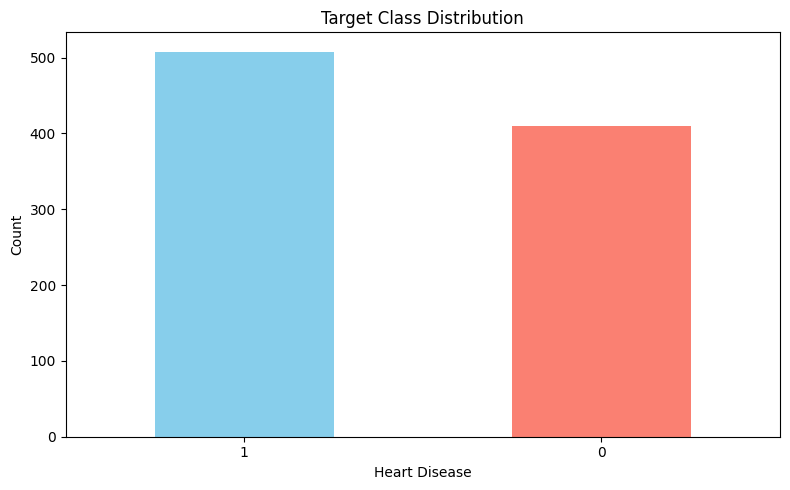

In [13]:
plt.figure(figsize=(8,5))
df[TARGET].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Target Class Distribution")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [15]:
df_clean = df.copy()

if df_clean.duplicated().sum() > 0:
    print(f"Dropping {df_clean.duplicated().sum()} duplicate rows.")
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)
else:
    print("No duplicates to drop.")

No duplicates to drop.


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in cat_cols:
    if col in df_clean.columns:
        df_clean[col] = le.fit_transform(df_clean[col])

num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if df_clean[c].isnull().any():
        med = df_clean[c].median()
        df_clean[c].fillna(med, inplace=True)
        print(f"Imputed numeric column {c} with median={med}")

In [17]:
print("Data preprocessing complete.")
print("\n=== Final dataset info ===")
print(df_clean.shape)
print(df_clean.isnull().sum().sum(), "total missing values")

Data preprocessing complete.

=== Final dataset info ===
(918, 12)
0 total missing values


# Classical SVM Models

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [19]:
# Prepare features and target

X = df_clean.drop('HeartDisease', axis=1)
y = df_clean['HeartDisease']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Kernel

In [22]:
linear_svm = SVC(kernel='linear', random_state=42)
linear_svm.fit(X_train_scaled, y_train)
y_pred_linear = linear_svm.predict(X_test_scaled)
acc_linear = accuracy_score(y_test, y_pred_linear)
print(f"Linear SVM Accuracy: {acc_linear:.4f}")
print(classification_report(y_test, y_pred_linear))

Linear SVM Accuracy: 0.8370
              precision    recall  f1-score   support

           0       0.78      0.86      0.81        77
           1       0.89      0.82      0.85       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184



## RBF Kernel

In [23]:
rbf_svm = SVC(kernel='rbf', random_state=42)
rbf_svm.fit(X_train_scaled, y_train)
y_pred_rbf = rbf_svm.predict(X_test_scaled)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF SVM Accuracy: {acc_rbf:.4f}")
print(classification_report(y_test, y_pred_rbf))

RBF SVM Accuracy: 0.8641
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



## Polynomial Kernel

In [25]:
poly_svm = SVC(kernel='poly', degree=3, random_state=42)
poly_svm.fit(X_train_scaled, y_train)
y_pred_poly = poly_svm.predict(X_test_scaled)
acc_poly = accuracy_score(y_test, y_pred_poly)
print(f"Polynomial SVM Accuracy: {acc_poly:.4f}")
print(classification_report(y_test, y_pred_poly))

Polynomial SVM Accuracy: 0.8315
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        77
           1       0.91      0.79      0.84       107

    accuracy                           0.83       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.83      0.83       184



# Quantum SVM Models

In [27]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from sklearn.preprocessing import MinMaxScaler
from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler

X_scaled = MinMaxScaler().fit_transform(X)
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Data prepared for quantum models")

Data prepared for quantum models


## Basis Encoding


In [28]:
print("Starting Basis Encoding...")
X_train_q_basis = X_train_q[:, :3]
X_test_q_basis = X_test_q[:, :3]

feature_map_basis = ZZFeatureMap(feature_dimension=3, reps=1)
quantum_kernel_basis = FidelityQuantumKernel(feature_map=feature_map_basis)

print("Training QSVC with Basis Encoding...")
qsvc_basis = QSVC(quantum_kernel=quantum_kernel_basis)
qsvc_basis.fit(X_train_q_basis, y_train_q)

print("Evaluating Basis Encoding...")
acc_basis = qsvc_basis.score(X_test_q_basis, y_test_q)
print(f"Basis Encoding Accuracy: {acc_basis:.4f}")


Starting Basis Encoding...
Training QSVC with Basis Encoding...
Evaluating Basis Encoding...
Basis Encoding Accuracy: 0.7935


## Amplitude Encoding


In [30]:
print("Starting Amplitude Encoding...")

X_train_q_amp = X_train_q[:, :2]
X_test_q_amp = X_test_q[:, :2]

feature_map_amp = ZZFeatureMap(feature_dimension=2, reps=1)
quantum_kernel_amp = FidelityQuantumKernel(feature_map=feature_map_amp)

print("Training QSVC with Amplitude Encoding...")
qsvc_amp = QSVC(quantum_kernel=quantum_kernel_amp)
qsvc_amp.fit(X_train_q_amp, y_train_q)

print("Evaluating Amplitude Encoding...")
acc_amp = qsvc_amp.score(X_test_q_amp, y_test_q)

print(f"Amplitude Encoding Accuracy: {acc_amp:.4f}")

Starting Amplitude Encoding...
Training QSVC with Amplitude Encoding...
Evaluating Amplitude Encoding...
Amplitude Encoding Accuracy: 0.6576


## Angle Encoding

In [31]:
print("Starting Angle Encoding...")

X_train_q_angle = X_train_q[:, :3]
X_test_q_angle = X_test_q[:, :3]

feature_map_angle = ZZFeatureMap(feature_dimension=3, reps=1)
quantum_kernel_angle = FidelityQuantumKernel(feature_map=feature_map_angle)

print("Training QSVC with Angle Encoding...")
qsvc_angle = QSVC(quantum_kernel=quantum_kernel_angle)
qsvc_angle.fit(X_train_q_angle, y_train_q)

print("Evaluating Angle Encoding...")
acc_angle = qsvc_angle.score(X_test_q_angle, y_test_q)

print(f"Angle Encoding Accuracy: {acc_angle:.4f}")

Starting Angle Encoding...
Training QSVC with Angle Encoding...
Evaluating Angle Encoding...
Angle Encoding Accuracy: 0.7935


# Results Comparison


In [33]:
# Accuracy comparison
results = {
    'Classical SVM': {
        'Linear': acc_linear,
        'RBF': acc_rbf,
        'Polynomial': acc_poly
    },
    'Quantum SVM': {
        'Basis Encoding': acc_basis,
        'Amplitude Encoding': acc_amp,
        'Angle Encoding': acc_angle
    }
}

print("\n" + "=" * 70)
print("ACCURACY COMPARISON")
print("=" * 70)
print("\nClassical SVM:")
for method, acc in results['Classical SVM'].items():
    print(f"  {method:15} - {acc:.4f}")

print("\nQuantum SVM:")
for method, acc in results['Quantum SVM'].items():
    print(f"  {method:15} - {acc:.4f}")

print("\n" + "=" * 70)
best_classical = max(results['Classical SVM'].items(), key=lambda x: x[1])
best_quantum = max(results['Quantum SVM'].items(), key=lambda x: x[1])
print(f"Best Classical SVM: {best_classical[0]} - {best_classical[1]:.4f}")
print(f"Best Quantum SVM: {best_quantum[0]} - {best_quantum[1]:.4f}")
print("=" * 70)


ACCURACY COMPARISON

Classical SVM:
  Linear          - 0.8370
  RBF             - 0.8641
  Polynomial      - 0.8315

Quantum SVM:
  Basis Encoding  - 0.7935
  Amplitude Encoding - 0.6576
  Angle Encoding  - 0.7935

Best Classical SVM: RBF - 0.8641
Best Quantum SVM: Basis Encoding - 0.7935


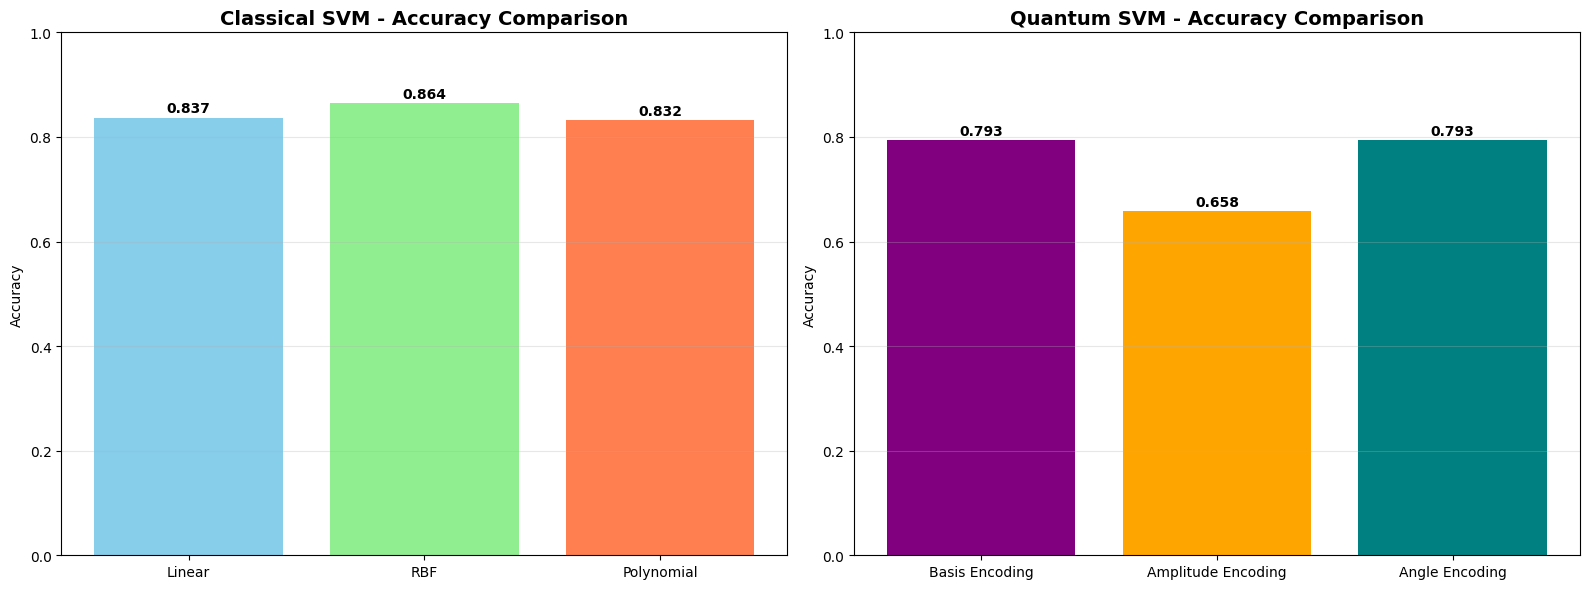

In [34]:
# Visualize accuracy comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Classical SVM comparison
methods_cls = list(results['Classical SVM'].keys())
accs_cls = list(results['Classical SVM'].values())
ax1.bar(methods_cls, accs_cls, color=['skyblue', 'lightgreen', 'coral'])
ax1.set_title('Classical SVM - Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(accs_cls):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Quantum SVM comparison
methods_q = list(results['Quantum SVM'].keys())
accs_q = list(results['Quantum SVM'].values())
ax2.bar(methods_q, accs_q, color=['purple', 'orange', 'teal'])
ax2.set_title('Quantum SVM - Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(accs_q):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

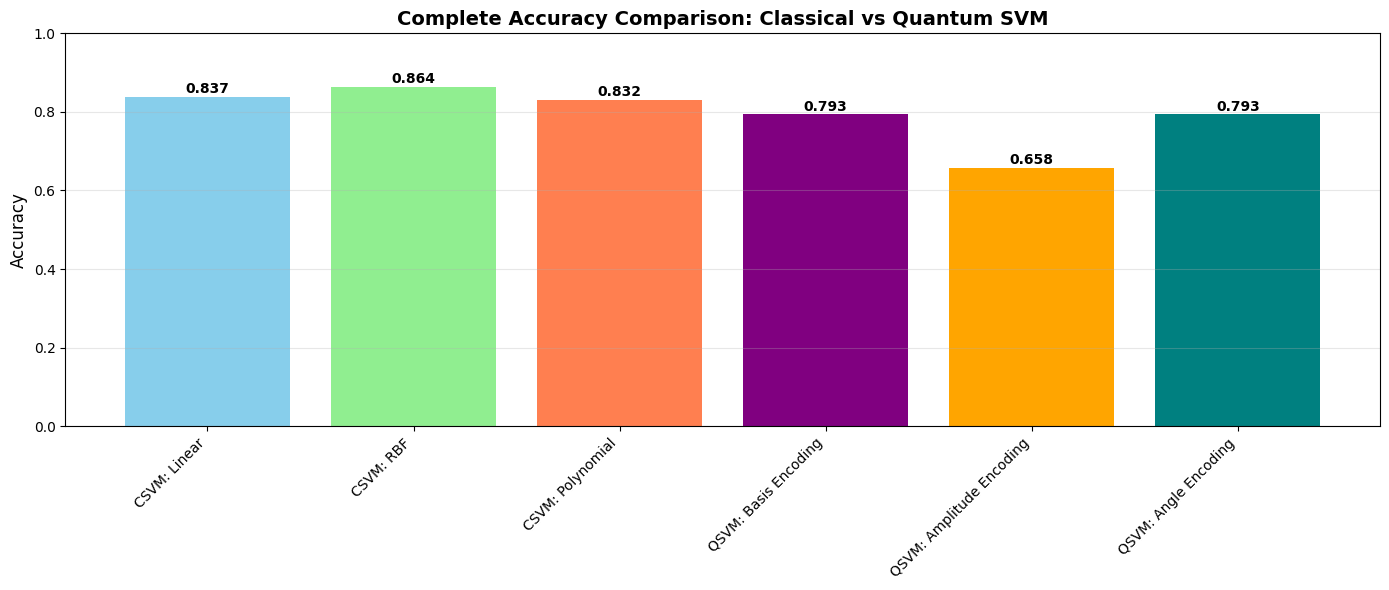

In [35]:
# Combined comparison
fig, ax = plt.subplots(figsize=(14, 6))
all_methods = [f"CSVM: {m}" for m in results['Classical SVM'].keys()] + \
              [f"QSVM: {m}" for m in results['Quantum SVM'].keys()]
all_accs = list(results['Classical SVM'].values()) + list(results['Quantum SVM'].values())
colors = ['skyblue', 'lightgreen', 'coral', 'purple', 'orange', 'teal']

bars = ax.bar(range(len(all_methods)), all_accs, color=colors)
ax.set_title('Complete Accuracy Comparison: Classical vs Quantum SVM', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xticks(range(len(all_methods)))
ax.set_xticklabels(all_methods, rotation=45, ha='right')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

for i, (method, acc) in enumerate(zip(all_methods, all_accs)):
    ax.text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

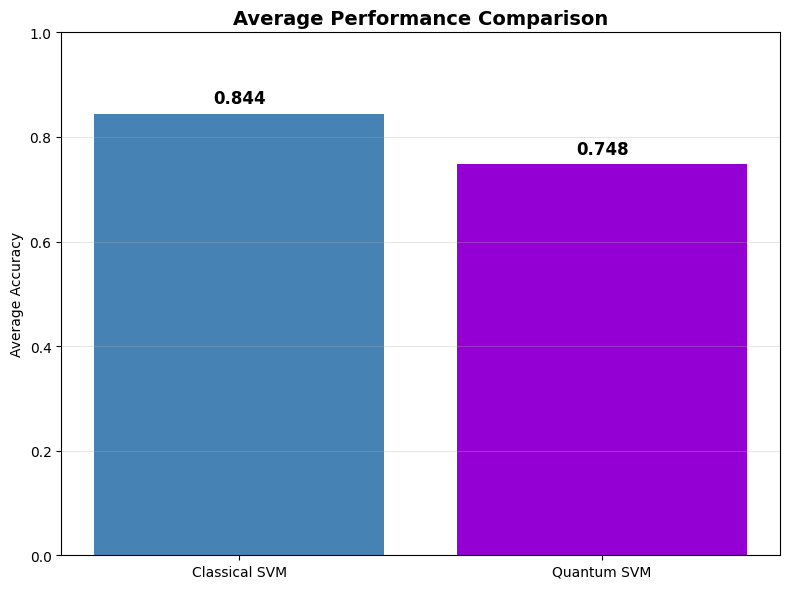


Average Classical SVM Accuracy: 0.8442
Average Quantum SVM Accuracy: 0.7482


In [36]:
# Average performance comparison
avg_classical = np.mean(list(results['Classical SVM'].values()))
avg_quantum = np.mean(list(results['Quantum SVM'].values()))

fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Classical SVM', 'Quantum SVM']
averages = [avg_classical, avg_quantum]
colors_bar = ['steelblue', 'darkviolet']

bars = ax.bar(categories, averages, color=colors_bar)
ax.set_title('Average Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Accuracy')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

for i, (cat, avg) in enumerate(zip(categories, averages)):
    ax.text(i, avg + 0.02, f'{avg:.3f}', ha='center', fontweight='bold', fontsize=12)
    
plt.tight_layout()
plt.show()

print(f"\nAverage Classical SVM Accuracy: {avg_classical:.4f}")
print(f"Average Quantum SVM Accuracy: {avg_quantum:.4f}")